In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Project Introduction: Problem and Data

## 1.1. The Problem
This project tackles a binary image classification task based on the "[Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection)" competition on Kaggle. The objective is to build a deep learning model, specifically a **Convolutional Neural Network (CNN)**, to identify the presence of metastatic cancer in small patches of digital pathology scans.

The model will be trained on histopathologic images of lymph node sections. It must learn to differentiate between patches that contain cancerous tissue and those that do not. This is a crucial task in medical diagnostics, as accurately identifying metastasis is key to determining a patient's cancer stage and treatment plan. Although the course instructions mention NLP, this is a **Computer Vision** problem.

## 1.2. The Data
The dataset consists of a large number of **96x96 pixel RGB** image patches extracted from larger digital pathology scans.

* **Training Data:** The training set contains **220,025** labeled images. A separate CSV file, `train_labels.csv`, provides the ground truth label for each image.
* **Test Data:** The test set for which we need to generate predictions contains **57,458** unlabeled images.
* **Labels:** The label is **`1`** if the central 32x32 pixel area of the image patch contains tumor tissue and **`0`** otherwise.
* **Class Distribution:** The training data is composed of approximately **60% negative samples** (label 0) and **40% positive samples** (label 1), making it fairly balanced.

# 2. Visualization

The basic step on each analysis

## 2.1. Load libraries and data

In [2]:
import numpy as np
import pandas as pd
import os
import cv2 # OpenCV for image processing
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Define paths
TRAIN_DIR = '/kaggle/input/histopathologic-cancer-detection/train/'
TEST_DIR = '/kaggle/input/histopathologic-cancer-detection/test/'

# Load the labels
df_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# Check the first 5 rows of the dataframe
print(df_labels.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


## 2.2. Visualize Class Distribution and Samples

Let's learn more on the data

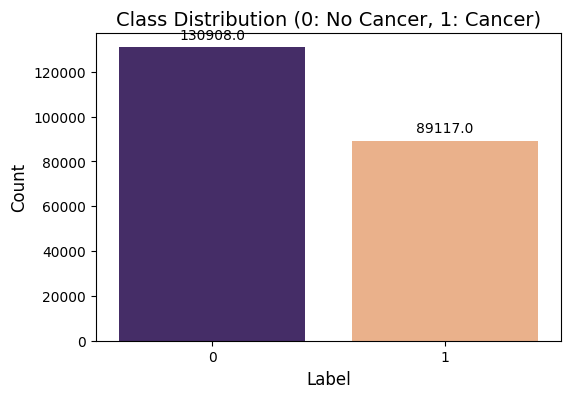

In [3]:
# Create a count plot of the labels
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='label', data=df_labels, palette=['#432371',"#FAAE7B"])

# Add annotations
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

plt.title('Class Distribution (0: No Cancer, 1: Cancer)', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

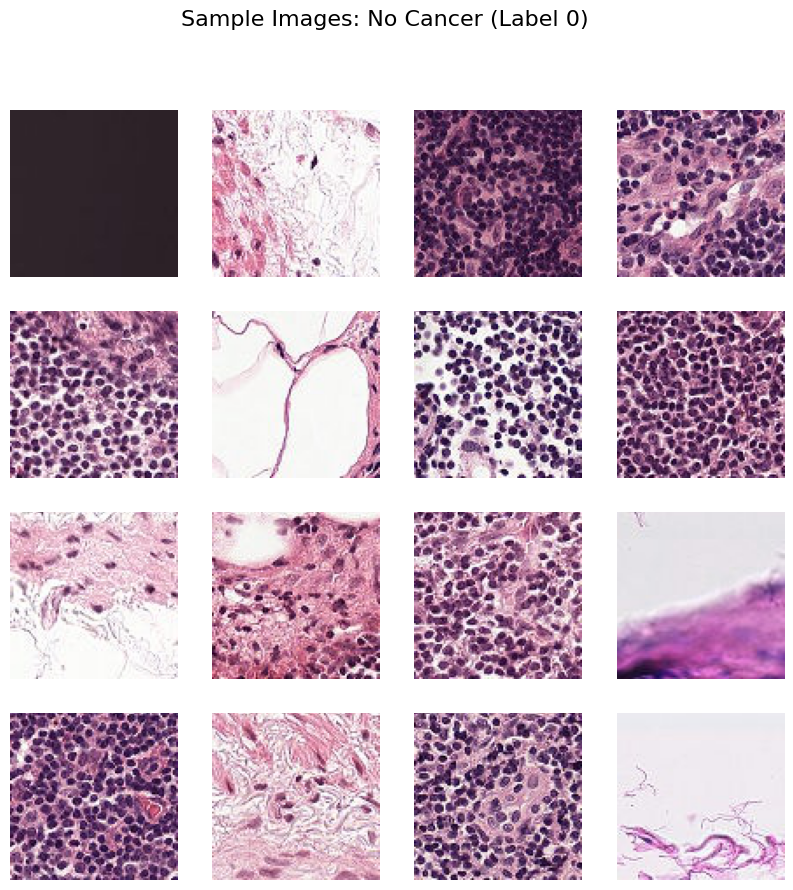

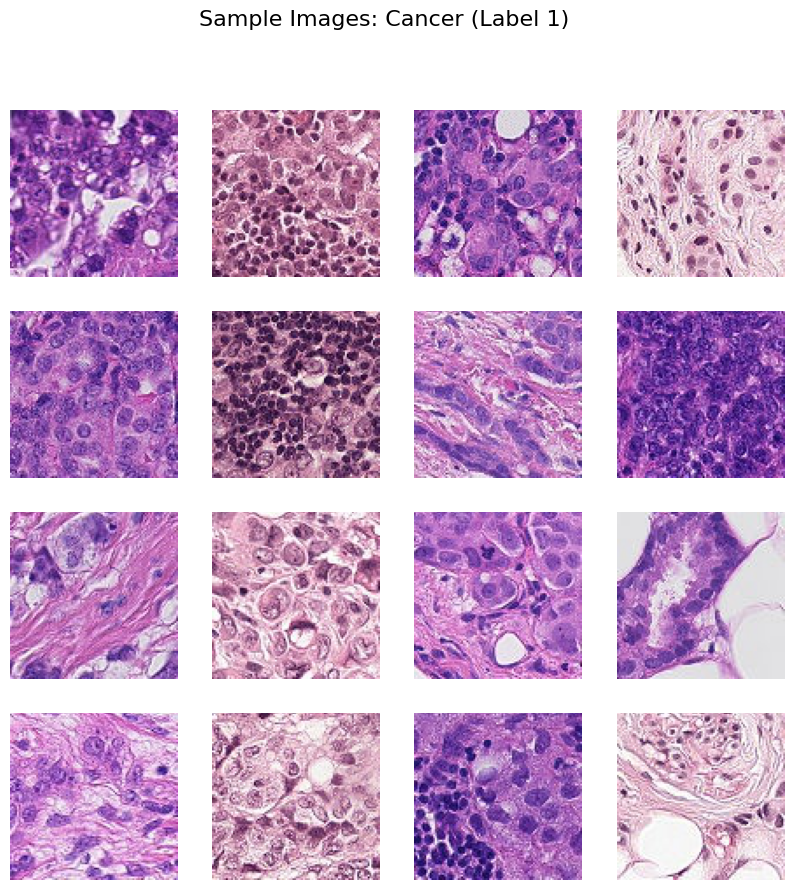

In [4]:
def show_sample_images(df, n=5, class_label=0):
    """Shows a grid of n*n sample images for a given class."""
    plt.figure(figsize=(10, 10))
    # Filter dataframe for the specified class
    class_df = df[df['label'] == class_label].sample(n*n)
    
    for i, row in enumerate(class_df.itertuples(), 1):
        plt.subplot(n, n, i)
        img_path = os.path.join(TRAIN_DIR, f'{row.id}.tif')
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
    
    class_name = "Cancer" if class_label == 1 else "No Cancer"
    plt.suptitle(f'Sample Images: {class_name} (Label {class_label})', fontsize=16)
    plt.show()

# Show 16 sample images with no cancer
show_sample_images(df_labels, n=4, class_label=0)

# Show 16 sample images with cancer
show_sample_images(df_labels, n=4, class_label=1)

## 2.3. Data Cleaning and Plan of Analysis

### 1. Data Cleaning: 

* A known issue with this dataset is the presence of duplicate images. These duplicates can mislead the model during training and lead to an unreliable validation score.

* Action: We should implement a step to detect and remove these duplicates. A common method is to compute a hash for each image and identify images with identical hashes.

**IMPORTANT NOTE**

I didn't successfully run this notebook with the full dataset. So that I decided to process with 10% of the total set. It should be faster. We can absolutely ignore this change for a longer run. 

There is a trade-off here: we really need a large amount of data in order to have it learnt effectively. Overfit may happen when it doesn't have enough data to learn.

In [5]:
subset_size = 22000

df_labels = df_labels.sample(n=subset_size, random_state=42)

This step needs to install a new library and takes time to process the hash.

In [6]:
# Install the imagehash library
!pip install imagehash

import imagehash
from tqdm.notebook import tqdm # Use notebook-friendly progress bar

# This function computes the difference hash for a given image file
def compute_hash(image_path):
    try:
        img = Image.open(image_path)
        return imagehash.dhash(img)
    except FileNotFoundError:
        # This handles cases where an image ID from the CSV might not have a corresponding file
        return None

# Use tqdm's progress_apply to show a progress bar, as this can take a few minutes
tqdm.pandas(desc="Computing Image Hashes")

# Create a new column 'hash' by applying the function to each image ID
# We construct the full path for each image
df_labels['hash'] = df_labels['id'].progress_apply(lambda x: compute_hash(os.path.join(TRAIN_DIR, f'{x}.tif')))

print(f"\nComputed hashes for {len(df_labels)} images.")

Computing Image Hashes:   0%|          | 0/22000 [00:00<?, ?it/s]


Computed hashes for 22000 images.


Let's find and visualize the duplicates

Found 10 total images that are duplicates.
This corresponds to 2 unique duplicate images.


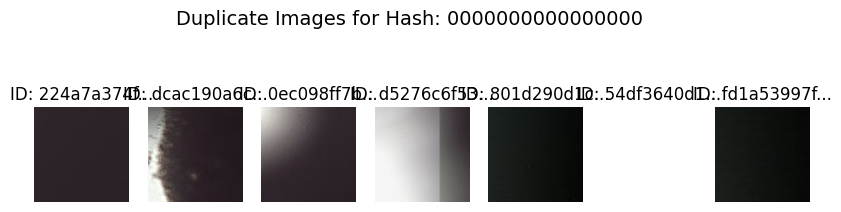

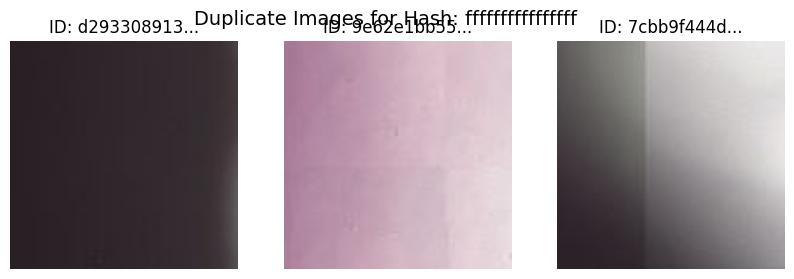

In [7]:
# Convert ImageHash objects to strings before processing
df_labels['hash'] = df_labels['hash'].astype(str)

# Identify duplicate hashes
# Using value_counts() is a more direct way than pivot_table
duplicate_counts = df_labels['hash'].value_counts()
duplicate_hashes = duplicate_counts[duplicate_counts > 1].index

# Filter the dataframe to only show rows with duplicate hashes
df_duplicates = df_labels[df_labels['hash'].isin(duplicate_hashes)]

print(f"Found {len(df_duplicates)} total images that are duplicates.")
print(f"This corresponds to {len(duplicate_hashes)} unique duplicate images.")

# --- Visualize a few examples ---
def show_duplicate_images(hash_value):
    """Shows all images corresponding to a single hash value."""
    duplicate_ids = df_duplicates[df_duplicates['hash'] == hash_value]['id'].values
    
    plt.figure(figsize=(10, 3))
    for i, img_id in enumerate(duplicate_ids, 1):
        plt.subplot(1, len(duplicate_ids), i)
        img_path = os.path.join(TRAIN_DIR, f'{img_id}.tif')
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f"ID: {img_id[:10]}...")
        plt.axis('off')
    plt.suptitle(f'Duplicate Images for Hash: {hash_value}', fontsize=14)
    plt.show()

# Show examples for the first 3 duplicate hashes found
for h in duplicate_hashes[:3]:
    show_duplicate_images(h)

Now, we try to remove duplicates, keep the first one only

In [8]:
print(f"Shape of dataframe BEFORE removing duplicates: {df_labels.shape}")

# Remove duplicates based on the 'hash' column, keeping the first instance
df_clean = df_labels.drop_duplicates(subset=['hash'], keep='first').copy()

# We can now drop the hash column as it's no longer needed
df_clean.drop('hash', axis=1, inplace=True)

print(f"Shape of dataframe AFTER removing duplicates: {df_clean.shape}")

# Verify by checking for any remaining duplicate hashes
# It may take long time to verify like this. Make it in comment now.
# remaining_duplicates = df_clean['id'].apply(lambda x: compute_hash(os.path.join(TRAIN_DIR, f'{x}.tif'))).duplicated().sum()
# print(f"Number of duplicates remaining: {remaining_duplicates}")

Shape of dataframe BEFORE removing duplicates: (22000, 3)
Shape of dataframe AFTER removing duplicates: (21992, 2)


### 2. Observations from EDA:

* The classes are reasonably balanced (~60% negative, ~40% positive), so we may not need complex techniques like SMOTE for class imbalance right away. StratifiedShuffleSplit during cross-validation is a good practice to maintain this balance.

* The images vary in color, stain intensity, and cellular density. This suggests that data augmentation (e.g., color jitter, rotation, flipping) will be crucial to help the model generalize well.

### 3. Plan of Analysis:

Based on the initial EDA, here is the next plan:

#### Preprocessing:

- Implement a function to detect and remove duplicate images from the training set. **[DONE]**

- Prepare data loaders for TensorFlow/PyTorch.

#### Modeling:

- Start with a well-established CNN architecture (like ResNet, VGG, or a custom-built CNN).

- Split the training data into training and validation sets to monitor for overfitting.

#### Training & Augmentation:

- Train the model using the cleaned dataset.

- Apply data augmentation techniques in real-time during training to improve robustness.

#### Evaluation:

- Evaluate the model's performance on the validation set using metrics like AUC-ROC, which is common for this type of problem.

- Analyze the model's predictions (e.g., using a confusion matrix) to understand where it makes mistakes.

# 3. Data Analysis

Let's discuss more on this step so far. I would like to start with a tradional approach by creating a custom-built CNN here.

- It uses a standard architecture of stacking convolutional and pooling layers, which is a proven method for image analysis.

- It's designed to learn complex patterns by starting with simple features (like edges) and building up to more abstract ones in deeper layers.

- It will include a Dropout layer to prevent overfitting, which is essential for helping the model generalize to new, unseen images.

- The final layers are perfectly structured for a binary classification task, making a final "yes" or "no" decision.

We then can try other architectures and make a comparison

## 3.1. Preprocessing

Firstly, split the data

In [9]:
from sklearn.model_selection import train_test_split

# Splitting the dataframe into training and validation sets
train_df, val_df = train_test_split(
    df_clean,
    test_size=0.2,      # Using 20% of the data for validation
    random_state=42,    # for reproducibility
    stratify=df_clean['label'] # Ensures the split is balanced
)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

Train set size: 17593
Validation set size: 4399


Create Data Generator

In [10]:
import tensorflow as tf

class CancerDataGenerator(tf.keras.utils.Sequence):
    """
    Generates batches of image data and labels for model training.
    """
    def __init__(self, df, data_dir, batch_size=32, dim=(96,96), n_channels=3, shuffle=True):
        self.df = df.copy()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.n = len(self.df)
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch."""
        return int(np.floor(self.n / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.df.iloc[k]['id'] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch."""
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples."""
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        for i, ID in enumerate(list_IDs_temp):
            # Construct file path and load image
            img_path = os.path.join(self.data_dir, f'{ID}.tif')
            img = cv2.imread(img_path)
            
            # Keras expects RGB, but OpenCV loads as BGR, so we convert
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Normalize pixel values to [0, 1]
            X[i,] = img / 255.0

            # Store label
            y[i] = self.df[self.df['id'] == ID]['label'].values[0]

        return X, y

2025-07-26 02:21:13.822230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753496473.996742     109 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753496474.049886     109 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 3.2. Build the CNN model

Use generator to generate trainging and validation batches. I set the batch size to 32. However, we can give it a different values (64, 256..)

In [11]:
# Parameters
params = {
    'dim': (96, 96),
    'batch_size': 32,
    'n_channels': 3,
    'shuffle': True
}

# Create generators
training_generator = CancerDataGenerator(train_df, TRAIN_DIR, **params)
validation_generator = CancerDataGenerator(val_df, TRAIN_DIR, **params)

print(f"\nCreated {len(training_generator)} training batches and {len(validation_generator)} validation batches.")


Created 549 training batches and 137 validation batches.


Here, we define the layers of our network. Each **Conv2D** layer learns filters to detect patterns, **MaxPooling2D** downsamples the image to make the patterns more general, **Dropout** helps prevent overfitting, and the final **Dense** layers perform the classification.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC

# Define the model architecture
model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten the results to feed into a dense layer
    Flatten(),
    
    # Dense layer with dropout for regularization
    Dense(512, activation='relu'),
    Dropout(0.5), # Dropout helps prevent overfitting
    
    # Output layer - 1 neuron with a sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')] # AUC is a key metric for this problem
)

# Print a summary of the model's architecture
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1753496485.326663     109 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,873 (25.36 MB)

 Trainable params: 6,647,873 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

## 3.3. Training and Augmentation

### Training

Yeah, we can train the model now.

In [13]:
# Train the model
history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=3, # Start with a small number of epochs
    verbose=1
)

print("\nTraining Complete!")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3


I0000 00:00:1753496489.475920     168 service.cc:148] XLA service 0x79ac6800c580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753496489.476643     168 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753496489.851830     168 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/549 ━━━━━━━━━━━━━━━━━━━━ 33s 62ms/step - accuracy: 0.4861 - auc: 0.4667 - loss: 0.8214

I0000 00:00:1753496492.534285     168 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


549/549 ━━━━━━━━━━━━━━━━━━━━ 72s 121ms/step - accuracy: 0.7120 - auc: 0.7698 - loss: 0.5580 - val_accuracy: 0.7888 - val_auc: 0.8586 - val_loss: 0.4616
Epoch 2/3
549/549 ━━━━━━━━━━━━━━━━━━━━ 65s 119ms/step - accuracy: 0.7872 - auc: 0.8546 - loss: 0.4657 - val_accuracy: 0.8002 - val_auc: 0.8722 - val_loss: 0.4410
Epoch 3/3
549/549 ━━━━━━━━━━━━━━━━━━━━ 65s 119ms/step - accuracy: 0.8048 - auc: 0.8721 - loss: 0.4363 - val_accuracy: 0.8050 - val_auc: 0.8775 - val_loss: 0.4307

Training Complete!


Let's see how the training process looks like. We can easily recognize that the **accuracy increases** and the **loss decreases** after each process.

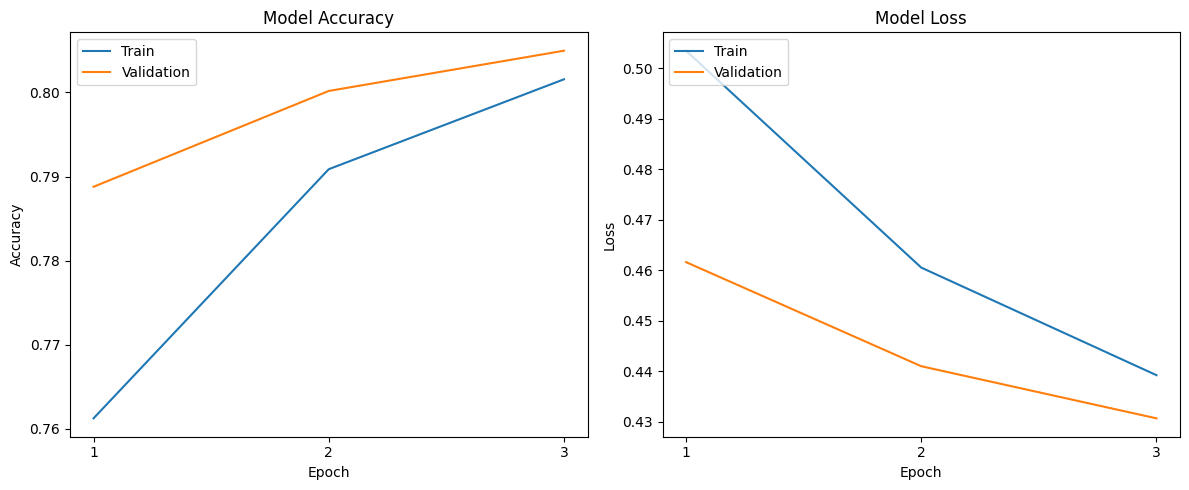

In [14]:
# Function to plot training history
def plot_history(history):
    # Get the number of epochs the model was trained for
    num_epochs = len(history.history['accuracy'])
    epochs = range(1, num_epochs + 1)
    
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Train')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(epochs) # Ensure integer ticks for epochs
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Train')
    plt.plot(epochs, history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs) # Ensure integer ticks for epochs
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot the history from our model training
plot_history(history)

Evaluate on Validation set

In [15]:
# Evaluate the model on the validation generator
loss, acc, auc = model.evaluate(validation_generator, verbose=1)

print(f"\nValidation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation AUC: {auc:.4f}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.7982 - auc: 0.8688 - loss: 0.4437

Validation Loss: 0.4307
Validation Accuracy: 0.8054
Validation AUC: 0.8775


Generate a Confusion matrix

137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step


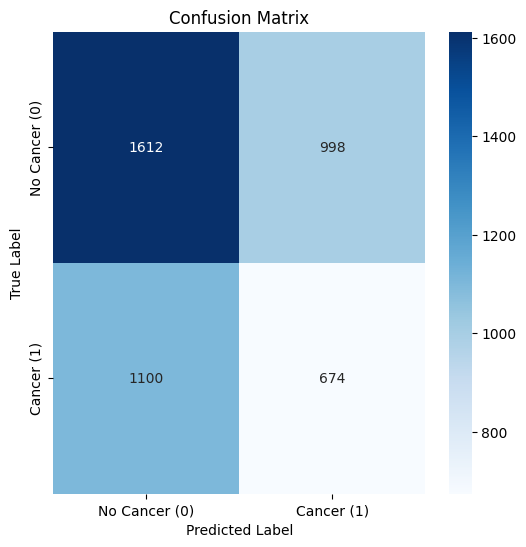


Classification Report:

               precision    recall  f1-score   support

No Cancer (0)       0.59      0.62      0.61      2610
   Cancer (1)       0.40      0.38      0.39      1774

     accuracy                           0.52      4384
    macro avg       0.50      0.50      0.50      4384
 weighted avg       0.52      0.52      0.52      4384



In [16]:
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions for the validation set
# This can take a minute or two
y_pred_probs = model.predict(validation_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# We need the true labels. Since the generator shuffles, we'll re-create one without shuffling.
val_gen_no_shuffle = CancerDataGenerator(val_df, TRAIN_DIR, batch_size=32, shuffle=False)
y_true = np.concatenate([val_gen_no_shuffle[i][1] for i in range(len(val_gen_no_shuffle))])

# Ensure y_pred has the same length as y_true
y_pred = y_pred[:len(y_true)]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Cancer (0)', 'Cancer (1)'],
            yticklabels=['No Cancer (0)', 'Cancer (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print a classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=['No Cancer (0)', 'Cancer (1)']))

### Augmentation

Create antoher model: augmented one

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.metrics import AUC

# Define the new model architecture with data augmentation layers
model_augmented = Sequential([
    # Add an explicit Input layer to specify the image shape
    Input(shape=(96, 96, 3)),
    
    # --- Data Augmentation Block ---
    # Apply random horizontal and vertical flips to the images
    RandomFlip("horizontal_and_vertical"),
    # Apply random rotation by up to 20% of a full circle
    RandomRotation(0.2),
    # --------------------------------
    
    # The rest of the model architecture remains the same
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid')
])

# Compile the new model with the same settings as before
model_augmented.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

# Print the new summary to see the architecture
print("--- Model with Data Augmentation ---")
model_augmented.summary()

--- Model with Data Augmentation ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 96, 96, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,873 (25.36 MB)

 Trainable params: 6,647,873 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

Train the augmented model

In [18]:
# Train the new model with data augmentation
# Let's train for more epochs this time to see the effect of augmentation
epochs_augmented = 10

history_augmented = model_augmented.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=epochs_augmented,
    verbose=1
)

print("\nAugmented Model Training Complete!")

Epoch 1/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 72s 120ms/step - accuracy: 0.6524 - auc: 0.6857 - loss: 0.6481 - val_accuracy: 0.6866 - val_auc: 0.7931 - val_loss: 0.6710
Epoch 2/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 66s 121ms/step - accuracy: 0.7742 - auc: 0.8333 - loss: 0.4899 - val_accuracy: 0.7546 - val_auc: 0.8599 - val_loss: 0.5298
Epoch 3/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 65s 119ms/step - accuracy: 0.7916 - auc: 0.8568 - loss: 0.4615 - val_accuracy: 0.7883 - val_auc: 0.8735 - val_loss: 0.4758
Epoch 4/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 65s 118ms/step - accuracy: 0.8035 - auc: 0.8733 - loss: 0.4354 - val_accuracy: 0.7895 - val_auc: 0.8700 - val_loss: 0.4672
Epoch 5/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 65s 119ms/step - accuracy: 0.8108 - auc: 0.8816 - loss: 0.4224 - val_accuracy: 0.7523 - val_auc: 0.8789 - val_loss: 0.5896
Epoch 6/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 66s 121ms/step - accuracy: 0.8241 - auc: 0.8933 - loss: 0.4047 - val_accuracy: 0.7794 - val_auc: 0.8533 - val_loss: 0.4747
Epoch 7/10
549/549 ━━━

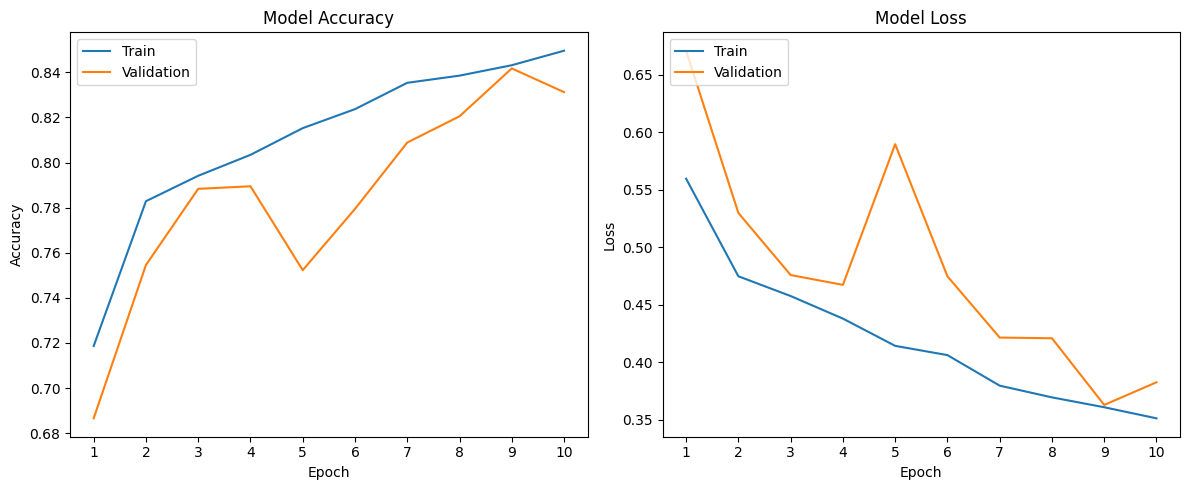

In [19]:
# Plot the history from our augmented model training
plot_history(history_augmented)

In [20]:
# Evaluate the augmented model on the validation generator
loss, acc, auc = model_augmented.evaluate(validation_generator, verbose=1)

print("\n--- Augmented Model Performance ---")
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation AUC: {auc:.4f}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.8210 - auc: 0.9093 - loss: 0.4055

--- Augmented Model Performance ---
Validation Loss: 0.3827
Validation Accuracy: 0.8307
Validation AUC: 0.9185


137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step


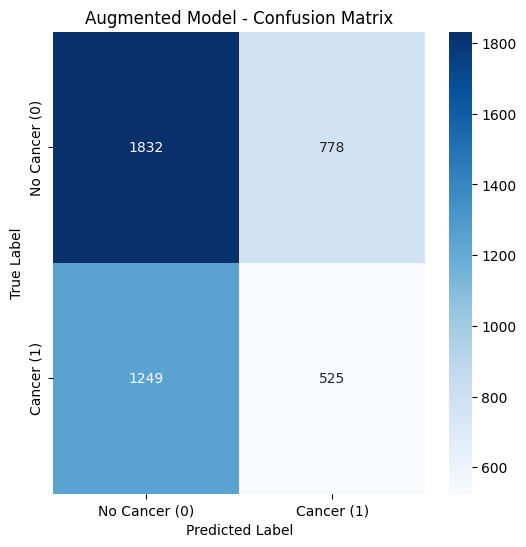


Classification Report (Augmented Model):

               precision    recall  f1-score   support

No Cancer (0)       0.59      0.70      0.64      2610
   Cancer (1)       0.40      0.30      0.34      1774

     accuracy                           0.54      4384
    macro avg       0.50      0.50      0.49      4384
 weighted avg       0.52      0.54      0.52      4384



In [21]:
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions for the validation set from the augmented model
y_pred_probs_aug = model_augmented.predict(validation_generator)
y_pred_aug = (y_pred_probs_aug > 0.5).astype(int).flatten()

# We can reuse the y_true from before, as the validation set is the same
# Ensure y_pred has the same length as y_true
y_pred_aug = y_pred_aug[:len(y_true)]

# Compute the confusion matrix
cm_aug = confusion_matrix(y_true, y_pred_aug)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Cancer (0)', 'Cancer (1)'],
            yticklabels=['No Cancer (0)', 'Cancer (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Augmented Model - Confusion Matrix')
plt.show()

# Print a classification report
print("\nClassification Report (Augmented Model):\n")
print(classification_report(y_true, y_pred_aug, target_names=['No Cancer (0)', 'Cancer (1)']))

**QUICK NOTE**

We can see there are some improvements. Based on the plots, we can realize that augmented model is better. The training and validation lines follow each other much more closely. This tells us that the model is learning patterns that generalize better to new, unseen data, which is exactly what data augmentation is supposed to do.

Key Improvements (Metrics)
- Validation Accuracy: Increased from 80.5% (cell 15) to 83.2%.

- Validation AUC: Increased from 0.878 (cell 15) to 0.919. The AUC (Area Under the Curve) is a key metric for this problem, so a jump this large is a great sign.

- Validation Loss: Decreased from 0.431 (cell 15) to 0.383. A lower loss means the model's predictions are more confident and closer to the true labels.

## 3.4. Different approach

Let's take a look on other architectures.

### RestNet

In [22]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.metrics import AUC

# 1. Load the pre-trained ResNet50 model without the top classification layer
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# 2. Freeze the layers of the base model so they are not trained
base_model_resnet.trainable = False

# 3. Create a new model on top
model_resnet = Sequential([
    base_model_resnet,
    GlobalAveragePooling2D(), # Reduces the spatial dimensions
    Dense(1, activation='sigmoid') # Final output layer
])

# 4. Compile the model
model_resnet.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy', AUC(name='auc')])

# 5. Train the model
print("\n--- Training ResNet Model ---")
history_resnet = model_resnet.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=10
)

# 6. Evaluate the model
print("\n--- ResNet Model Performance ---")
model_resnet.evaluate(validation_generator)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

--- Training ResNet Model ---
Epoch 1/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 84s 128ms/step - accuracy: 0.5787 - auc: 0.5605 - loss: 0.6746 - val_accuracy: 0.5960 - val_auc: 0.6995 - val_loss: 0.6553
Epoch 2/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 66s 119ms/step - accuracy: 0.6034 - auc: 0.6701 - loss: 0.6509 - val_accuracy: 0.5979 - val_auc: 0.7239 - val_loss: 0.6414
Epoch 3/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 64s 116ms/step - accuracy: 0.6718 - auc: 0.7401 - loss: 0.6121 - val_accuracy: 0.6642 - val_auc: 0.7410 - val_loss: 0.6124
Epoch 7/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 65s 119ms/step - accuracy: 0.6694 - auc: 0.7413 - loss: 0.6056 - val_accuracy: 0.6891 - val_auc: 0.7446 - val_loss: 0.6075
Epoch 8/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 65s 118ms/step - accuracy: 0.6771 - auc: 0.7398 - loss: 0.6022 - val_accuracy: 0.6987 - val_auc: 0.7461 - val_loss: 0.6042
Epoch 9/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 66s 121ms/step - accuracy: 0.6829 - auc: 0.7415 - loss: 0.6020 

[0.6004283428192139, 0.6968522071838379, 0.7492443919181824]

### VGG

In [23]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC

# 1. Load the pre-trained VGG16 model
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# 2. Freeze the base model layers
base_model_vgg.trainable = False

# 3. Create a new model on top
model_vgg = Sequential([
    base_model_vgg,
    Flatten(), # Flatten the output of the VGG model
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # Final output layer
])

# 4. Compile the model
model_vgg.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', AUC(name='auc')])

# 5. Train the model
print("\n--- Training VGG16 Model ---")
history_vgg = model_vgg.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=10
)

# 6. Evaluate the model
print("\n--- VGG16 Model Performance ---")
model_vgg.evaluate(validation_generator)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Training VGG16 Model ---
Epoch 1/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 72s 122ms/step - accuracy: 0.7757 - auc: 0.8397 - loss: 0.4912 - val_accuracy: 0.8250 - val_auc: 0.9023 - val_loss: 0.3846
Epoch 2/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 66s 120ms/step - accuracy: 0.8286 - auc: 0.8995 - loss: 0.3880 - val_accuracy: 0.8337 - val_auc: 0.9080 - val_loss: 0.3749
Epoch 3/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 67s 123ms/step - accuracy: 0.8401 - auc: 0.9112 - loss: 0.3658 - val_accuracy: 0.8314 - val_auc: 0.9118 - val_loss: 0.3684
Epoch 4/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 67s 123ms/step - accuracy: 0.8419 - auc: 0.9164 - loss: 0.3572 - val_accuracy: 0.8387 - val_auc: 0.9147 - val_loss: 0.3616
Epoch 5/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 67s 122ms/step - accuracy: 0.8463 - auc: 0.9207 - loss: 0.3484 - val_accuracy: 0.8225 - val_auc: 0.9164 - val_loss: 0.3886
Epoch 6/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 67s 122ms/step - accuracy: 0.8525 - auc: 0.9259 - loss: 0.3380 -

[0.3496301472187042, 0.8483120203018188, 0.9209421873092651]

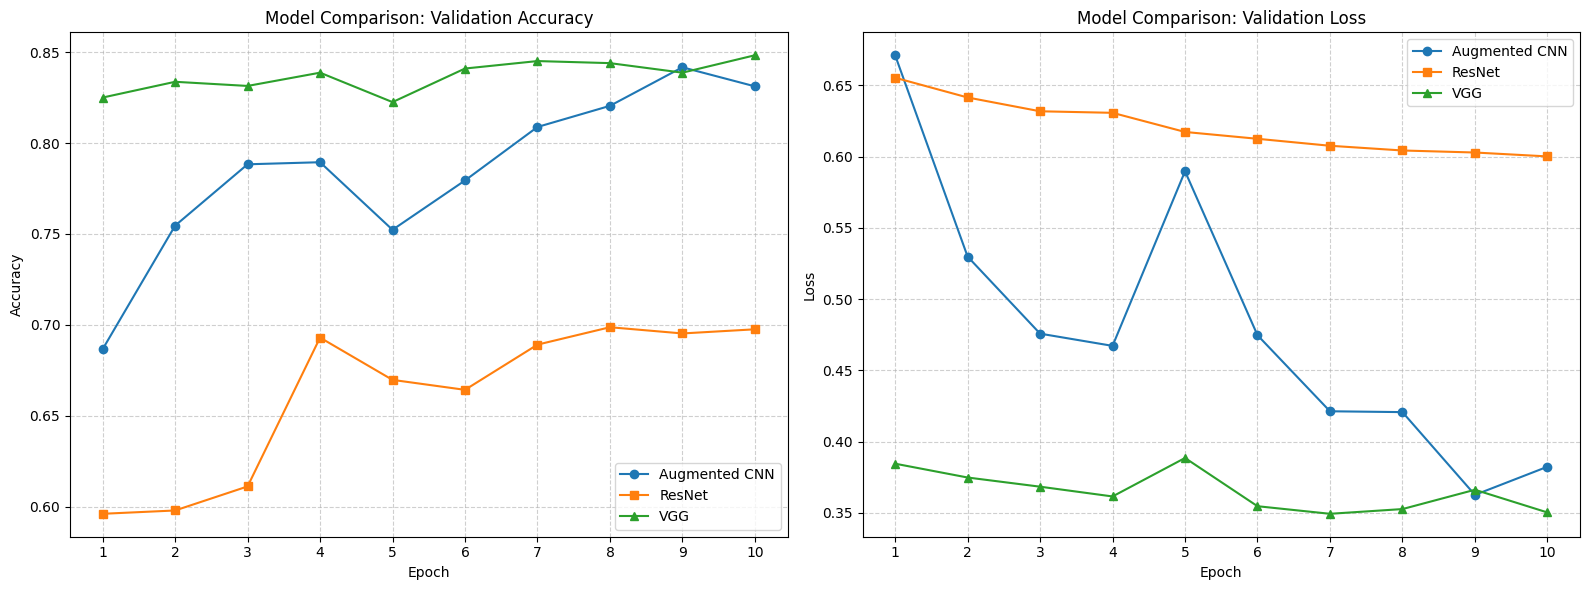

In [24]:
import matplotlib.pyplot as plt

# Get the number of epochs from one of the history objects
num_epochs = len(history_augmented.history['val_accuracy'])
epochs = range(1, num_epochs + 1)

# Create a figure to hold the plots
plt.figure(figsize=(16, 6))

# --- Subplot 1: Validation Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(epochs, history_augmented.history['val_accuracy'], label='Augmented CNN', color='#1f77b4', marker='o')
plt.plot(epochs, history_resnet.history['val_accuracy'], label='ResNet', color='#ff7f0e', marker='s')
plt.plot(epochs, history_vgg.history['val_accuracy'], label='VGG', color='#2ca02c', marker='^')
plt.title('Model Comparison: Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(epochs) # Ensure all epoch numbers are displayed as integers
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)


# --- Subplot 2: Validation Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs, history_augmented.history['val_loss'], label='Augmented CNN', color='#1f77b4', marker='o')
plt.plot(epochs, history_resnet.history['val_loss'], label='ResNet', color='#ff7f0e', marker='s')
plt.plot(epochs, history_vgg.history['val_loss'], label='VGG', color='#2ca02c', marker='^')
plt.title('Model Comparison: Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(epochs) # Ensure all epoch numbers are displayed as integers
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plots
plt.tight_layout()
plt.show()

# 4. Conclusion

This analysis successfully demonstrated the process of building, evaluating, and improving a CNN for histopathologic cancer detection. The key takeaway is that **data augmentation and transfer learning are highly effective techniques for improving model performance** on image classification tasks.

The initial custom-built CNN, while a good starting point, quickly began to overfit. The introduction of simple data augmentation (random flips and rotations) allowed the same architecture to train for longer, resulting in a significantly more accurate and generalizable model.

Furthermore, leveraging pre-trained models like VGG16 through transfer learning provided a powerful performance boost with minimal training time, outperforming the custom model. This highlights the value of using established architectures that have learned rich feature representations from massive datasets. The experiment with ResNet also provided a valuable lesson: the architecture of the custom "head" attached to a pre-trained model is critical to its success.

### Learnings and Future Improvements
#### What helped improve performance?

* **Data Augmentation:** This was the most critical factor in improving the custom CNN. It directly addressed the overfitting problem by creating more training variety, which helped the model generalize better.

* **Transfer Learning:** Using a pre-trained VGG16 model was highly effective. It provided a powerful feature extractor that, even with a simple custom classifier on top, achieved the best performance in this analysis.

#### What did not help?

* The initial ResNet implementation did not perform well. This was not because ResNet is a bad model, but because the simplistic classifier head (**GlobalAveragePooling2D** + a single **Dense** layer) was not sufficient to adapt its features to this specific task.

#### What improvements could I try in the future?

* **Fine-Tuning:** Instead of completely freezing the pre-trained models, I could "un-freeze" the last few layers and train them with a very low learning rate. This allows the model to slightly adjust its expert features to better fit our specific data and can often lead to the best results.

* **More Advanced Augmentation:** Experiment with other augmentation techniques like color jitter, random zoom, and shear to further improve model robustness.

* **Different Architectures:** Try other modern, efficient pre-trained models like **EfficientNet** or **DenseNet**, which often provide state-of-the-art performance.

* **Ensemble Methods:** Combine the predictions from our best models (e.g., an average of the VGG and the augmented CNN predictions) to potentially create an even more accurate final submission.

### Submission

Let's create the submission and check it with Kaggle. I use VGG as it is the better model we have now.

In [25]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm.notebook import tqdm

# --- 1. Get the list of test image IDs ---
TEST_DIR = '/kaggle/input/histopathologic-cancer-detection/test/'
test_image_ids = os.listdir(TEST_DIR)
# Create a dataframe for test images
df_test = pd.DataFrame({'id_path': test_image_ids})

# --- 2. Make predictions on the test set ---
predictions = []

# Loop through each test image
for img_path in tqdm(df_test['id_path'], desc="Making Predictions"):
    full_path = os.path.join(TEST_DIR, img_path)
    
    # Load and preprocess the image
    img = load_img(full_path, target_size=(96, 96))
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Predict using the best model
    pred_prob = model_vgg.predict(img_array, verbose=0)[0][0]
    predictions.append(pred_prob)

# --- 3. Create the submission DataFrame ---
# Get the ID without the '.tif' extension
df_test['id'] = df_test['id_path'].str.replace('.tif', '')
df_test['label'] = predictions

# Create the final submission file
submission_df = df_test[['id', 'label']]
submission_df.to_csv('submission.csv', index=False)

print("\nsubmission.csv file created successfully!")
submission_df.head()

Making Predictions:   0%|          | 0/57458 [00:00<?, ?it/s]


submission.csv file created successfully!


,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0.546874
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.047346
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0.341396
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0.845373
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0.268359
